In [15]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='e4kYtUu20yct2oNYU-mcwccWAH5zcxWmUnC_xnE0jD6X',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.eu-de.cloud-object-storage.appdomain.cloud')

bucket = 'earthquakeprediction-donotdelete-pr-zjwckuhceushqy'
object_key = 'query.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head(10)



,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2014-01-01T23:51:36.020Z,33.663333,-116.777667,11.008,1.29,ml,39.0,51.00,0.067290,0.0900,...,2016-03-11T20:40:44.428Z,"10km SSW of Idyllwild, CA",earthquake,0.26,0.37,0.184,51.0,reviewed,ci,ci
1,2014-01-01T23:47:26.501Z,63.102000,-151.645900,14.100,1.10,ml,NaN,NaN,NaN,0.5700,...,2023-07-19T20:56:19.099Z,Central Alaska,earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak
2,2014-01-01T23:45:56.476Z,61.458100,-150.016500,44.600,1.20,ml,NaN,NaN,NaN,0.4700,...,2023-07-19T20:56:17.820Z,"7 km SSW of Big Lake, Alaska",earthquake,NaN,0.50,NaN,NaN,reviewed,ak,ak
3,2014-01-01T23:42:43.623Z,62.788400,-150.827600,87.600,1.40,ml,NaN,NaN,NaN,0.3500,...,2023-08-18T15:59:54.274Z,"32 km N of Petersville, Alaska",earthquake,NaN,0.70,NaN,NaN,reviewed,ak,ak
4,2014-01-01T23:42:15.000Z,-29.888000,-71.621000,40.000,4.00,ml,NaN,NaN,NaN,3.0900,...,2014-03-07T00:25:54.000Z,"28 km WNW of Coquimbo, Chile",earthquake,NaN,10.10,NaN,NaN,reviewed,guc,guc
5,2014-01-01T23:40:44.020Z,38.807167,-122.783997,0.013,0.53,md,8.0,90.00,0.007207,0.0300,...,2017-02-02T19:17:27.447Z,"5 km WSW of Cobb, California",earthquake,0.40,0.46,0.030,2.0,automatic,nc,nc
6,2014-01-01T23:38:03.870Z,37.643333,-118.894833,-0.446,0.70,md,16.0,133.00,0.001802,0.0800,...,2017-02-02T19:17:21.500Z,"6 km E of Mammoth Lakes, California",earthquake,0.30,0.16,0.475,16.0,reviewed,nc,nc
7,2014-01-01T23:36:42.290Z,33.517500,-116.562000,8.148,0.47,ml,17.0,92.00,0.040450,0.0900,...,2016-03-11T09:29:49.278Z,"11km ESE of Anza, CA",earthquake,0.38,0.58,0.113,8.0,reviewed,ci,ci
8,2014-01-01T23:32:26.923Z,38.567800,-118.464600,8.700,0.60,ml,5.0,155.68,0.075000,0.1066,...,2018-06-29T22:59:45.339Z,"14 km ENE of Hawthorne, Nevada",earthquake,NaN,10.70,0.890,4.0,reviewed,nn,nn
9,2014-01-01T23:32:17.530Z,-23.957600,-176.820700,219.290,4.20,mb,NaN,136.00,5.358000,1.3800,...,2014-03-07T00:25:54.000Z,south of the Fiji Islands,earthquake,NaN,12.10,0.372,5.0,reviewed,us,us


In [16]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

In [17]:
# Preprocess the data
X = df[['latitude', 'longitude', 'depth', 'mag', 'nst', 'gap', 'dmin', 'rms']]
y = df['type']

# Handle missing values (if any)
X = X.fillna(0)

# Identify categorical columns
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']


In [18]:
# Use ColumnTransformer to handle categorical variables properly
ct = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ], remainder='passthrough'
)

# Fit ColumnTransformer on X to identify categorical feature names
ct.fit(X)

# Transform X to include one-hot encoded categorical variables
X = ct.transform(X)



In [19]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# Use the trained model to make predictions on new data
new_data_transformed = ct.transform(new_data)

# Predict using the trained model
prediction = clf.predict(new_data_transformed)

In [20]:
# Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='earthquake')
recall = recall_score(y_test, y_pred, pos_label='earthquake')
f1 = f1_score(y_test, y_pred, pos_label='earthquake')


/opt/conda/envs/Python-RT23.1/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [21]:
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


In [22]:
# Use the trained model to make predictions
new_data = pd.DataFrame({
    'latitude': [40.7128],
    'longitude': [-74.0060],
    'depth': [10],
    'mag': [5.0],
    'magType': ['us'],
    'nst': [50],
    'gap': [90],
    'dmin': [0.1],
    'rms': [0.5],
    'net': ['us'],
    'id': ['123'],
    'updated': ['2024-06-28'],
    'place': ['New York'],
    'type': ['earthquake'],
    'horizontalError': [0.5],
    'depthError': [0.2],
    'magError': [0.1],
    'magNst': [10],
    'status': ['automatic'],
    'locationSource': ['us'],
    'magSource': ['us']
})



In [23]:
if prediction[0] == 'earthquake':
    print('Earthquake predicted!')
else:
    print('No earthquake predicted.')

Earthquake predicted!


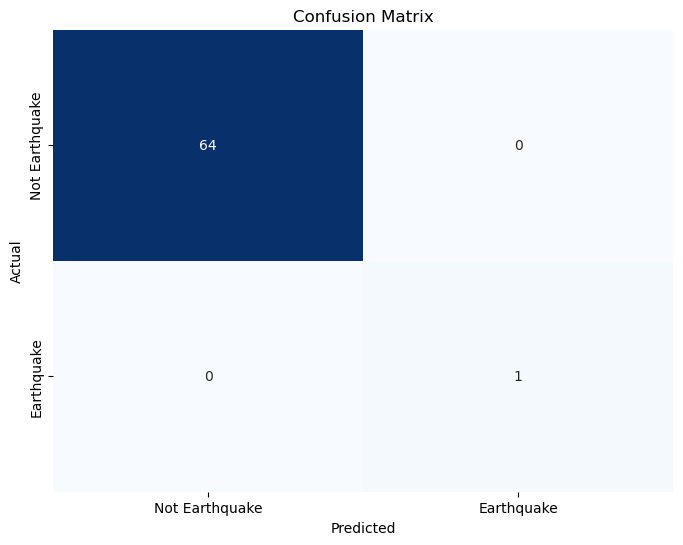

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Not Earthquake', 'Earthquake'],
            yticklabels=['Not Earthquake', 'Earthquake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


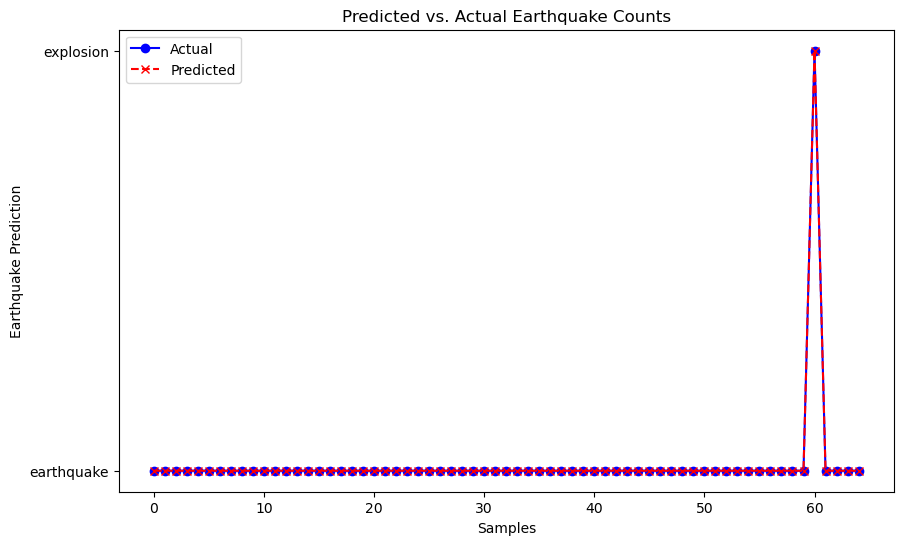

In [25]:
# Example plot comparing predicted and actual earthquake counts
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual', marker='o', linestyle='-', color='b')
plt.plot(range(len(y_pred)), y_pred, label='Predicted', marker='x', linestyle='--', color='r')
plt.xlabel('Samples')
plt.ylabel('Earthquake Prediction')
plt.title('Predicted vs. Actual Earthquake Counts')
plt.legend()
plt.show()
